In [125]:
%matplotlib inline
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l


首先，我们[**像以前一样生成一些数据**]，生成公式如下：

(**$$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.01^2).$$**)

我们选择标签是关于输入的线性函数。
标签同时被均值为0，标准差为0.01高斯噪声破坏。
为了使过拟合的效果更加明显，我们可以将问题的维数增加到$d = 200$，
并使用一个只包含20个样本的小训练集。

In [126]:
# 创建训练数据和测试数据
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)


In [127]:
# 初始化模型参数
def init_params():
    w = torch.normal(0,1,size = (num_inputs,1),requires_grad = True)
    b = torch.zeros(1,requires_grad= True)
    return [w,b]

In [128]:
# 初始化超参数
lr = 0.003
num_epochs = 100 # 训练100轮

In [129]:
def l2_penaltyu(w):
    return torch.sum(w.pow(2)) /2
    

In [139]:
def l1_penalty(w):
    return torch.sum(torch.abs(w))

In [130]:
def net(w,x,b):
    return torch.matmul(x,w) + b

In [131]:
def loss_squared(y_hat,y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [132]:
def sgd(params,lr,batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()


In [133]:
def train(lambd):
    # 定义模型
    w,b = init_params()
    loss = loss_squared
    # 定义损失函数
    
    # 开始训练
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    net= lambda X: d2l.linreg(X, w, b)
    for epoch in range(num_epochs):
        for x,y in train_iter:
            # 向前传播 -> 计算损失函数 -> 反向传播 -> 优化（更新参数）
            l = loss(net(x),y) + lambd * l2_penaltyu(w)
            l.sum().backward()
            sgd([w,b],lr,batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

In [146]:
def train_l1(lambd):
    # 定义模型
    w,b = init_params()
    loss = loss_squared
    # 定义损失函数
    
    # 开始训练
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    net= lambda X: d2l.linreg(X, w, b)
    for epoch in range(num_epochs):
        for x,y in train_iter:
            # 向前传播 -> 计算损失函数 -> 反向传播 -> 优化（更新参数）
            l = loss(net(x),y) + lambd * l1_penalty(w)
            l.sum().backward()
            sgd([w,b],lr,batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

w的L2范数是： 13.924795150756836


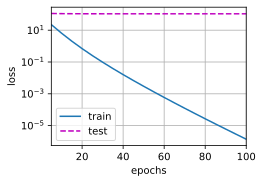

In [134]:
train(lambd=0)# test 损失不动，过拟合

w的L2范数是： 0.38831618428230286


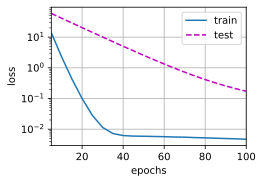

In [135]:
train(lambd = 3)

w的L2范数是： 0.2454001009464264


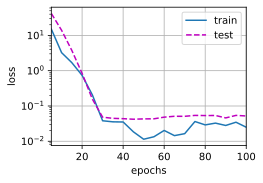

In [148]:
train_l1(lambd = 10)

w的L2范数是： 0.028540439903736115


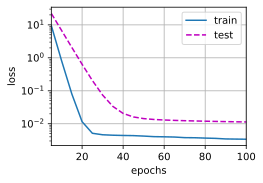

In [136]:
train(lambd = 10)

w的L2范数是： 0.23514080047607422


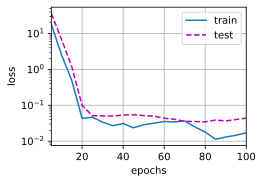

In [141]:
train_l1(lambd=10)

In [ ]:
def train_concise(wd):
    # wd 是衰退系数
    net = nn.Sequential(nn.Linear(num_inputs,1))

    for param in net.parameters():
        param.data.normal_()

    loss = nn.MSELoss(reduction = 'none')

    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay':wd},
        {"params":net[0].bias}
    ], lr = lr)

    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for x,y in train_iter:
            trainer.zero_grad()
            l = loss(net(x),y)
            l.mean().backward()
            trainer.step()

            if (epoch + 1) % 5 == 0:
                animator.add(epoch + 1,
                            (d2l.evaluate_loss(net, train_iter, loss),
                            d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())


w的L2范数： 0.13161124289035797


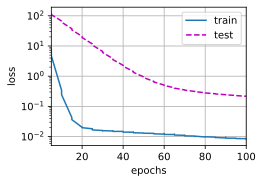

In [ ]:
train_concise(5)

# 简介实现要比手动实现慢好多

for param in nn.parameters()
param的属性和方法
- param.data 直接访问数据，返回结果是Tensor
    - 对数据再进行操作 param.data.normal_()
- param.size() == param.shape
- param.grad (如果没有反向传播，可能是None)
    - param.grad.shape  梯度的形状和范数的相同 = param.shape
    - param.grad.norm() 梯度的范数
- param.requires_grad = True 需要梯度
- param.device  参数所在的设备
    - param.data = param.data.to('cuda')
    - param.data = param.data.to('cpu')


降低参数的大小范围，避免因参数过大而造成曲线太敏感，太陡峭，所以可以使曲线变得平滑，避免过拟合